In [220]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [221]:
from tf_agents.agents import DdpgAgent,DqnAgent
from tf_agents.agents import ddpg,dqn
from tf_agents.utils import common
from tf_agents import networks
from tf_agents.networks import sequential
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import py_metrics
from tf_agents.drivers import py_driver,dynamic_episode_driver,dynamic_step_driver
from tf_agents.policies import random_py_policy,random_tf_policy,PyTFEagerPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer,py_uniform_replay_buffer

from tensorflow import Tensor,Variable
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import initializers



# Utils

In [403]:
class MyObserver:
    def __init__(self,verbose=False):
        self.results = []
        self.verbose = verbose
    def __call__(self,traj):
        obs = traj.observation
        if isinstance(obs,Tensor):
            obs = obs.numpy().copy()
        else:
            obs = obs.copy()
        self.results.append({"observation":obs,"reward":traj.reward,"traj":traj})
        if self.verbose:
            print("\tMyObserver:",traj.observation,traj.reward)
    def plot(self,ax=None,sample=None):
        n = len(self.results)
        x = list(range(n))
        if ax is None:
            fig,ax = plt.subplots()
        if sample is None:
            sample = len(self.results)
        sample=min(len(self.results),sample)
        results = self.results[-sample:]
        
        ax.plot([t.get("reward") for t in results])
#         plt.bar(x=x,height=[int(t.get("traj").is_last())*8 for t in results],color="g")
#         plt.bar(x=x,height=[int(t.get("traj").is_boundary())*8 for t in results],color="r")
#         plt.bar(x=x,height=[int(t.get("traj").is_first())*8 for t in results],color="k")
        return ax

In [404]:
class MyLogger:
    def __init__(self):
        self.logs = []
    def log(self,*args):
        self.logs.append(args)
    def reset(self):
        self.logs = []
    def __str__(self):
        return "\n".join(["\t".join(map(str,l)) for l in self.logs])

# PARAMETERS

In [405]:
nb_actions = 4
learning_rate_dqn = 0.001
learning_rate_actor = 0.001
learning_rate_critic = 0.001

num_iterations = 10000
replay_buffer_capacity = 10000


# Environments
## Version Python

In [406]:
class BinaryEnv(py_environment.PyEnvironment):
    def __init__(self,log=False):
        self._state = 0
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, name='observation')
        self._logger = MyLogger()
        
        self._episode_ended = False
        self.log = log

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = 0
        self._episode_ended = False
#         self._logger.reset()
        return ts.restart(np.array(self._state,dtype=np.int32))
#         return ts.restart(np.array([self._state], dtype=np.int32))
    

    def _step(self, action):
        """
        Remplit la action_ième case
        Termine si action déjà remplie
        """
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()
        if action == self._state:
            reward = -1
        else:
            reward = 0
            self._state = action
            self._episode_ended = True
        
        if not self._episode_ended:
             result = ts.transition(
                np.array(self._state,dtype=np.int32), reward=reward, discount=1)
#                 np.array([self._state], dtype=np.int32), reward=penalty, discount=0.95)
        
        else:
            result = ts.termination(np.array(self._state,dtype=np.int32), reward)
#             return ts.termination(np.array([self._state], dtype=np.int32), reward)
        if self.log:
            self._logger.log(result.observation,reward)
        return result

In [436]:
class IArchitectEnv(py_environment.PyEnvironment):
    def __init__(self,log=False,action_float=False,fail_on_same=True,max_iter=50):
        self._state = np.zeros((nb_actions,),dtype=np.int32)
        self._iter = 0
        self._max_iter = max_iter
        if action_float:
            self._action_spec = array_spec.BoundedArraySpec(
                shape=(), dtype=np.float32, minimum=-0.49, maximum=3.49, name='action')
        else:
            self._action_spec = array_spec.BoundedArraySpec(
                shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(self._state.shape[0],), dtype=np.int32, minimum=0, name='observation')
        self._logger = MyLogger()
        
        self._episode_ended = False
        self.log = log
        self.fail_on_same = fail_on_same


    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.zeros((nb_actions,),dtype=np.int32)
        self._iter = 0
        self._episode_ended = False
#         self._logger.reset()
        return ts.restart(self._state)
#         return ts.restart(np.array([self._state], dtype=np.int32))
    

    def _step(self, action):
        """
        Remplit la action_ième case
        Termine si action déjà remplie
        """
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()
        
        self._iter += 1

        # Make sure episodes don't go on forever.
        action_ = action.round().astype(int)
        
#         if self._state.sum()==0:
#             reward = 1
#             self._state[self._state.argmin()] = action_
#         else:
#             if self._state[self._state.argmax()]==action_:
#                 reward = 1
#                 self._state[self._state.argmin()] = action_
#             else:
#                 reward = 0
#                 self._episode_ended = True            
#             if self._state[self._state.argmin()]!=0:
#                 reward = 1 
#                 self._episode_ended = True
                
        
        
        assert action_ in list(range(self._state.shape[0]))
        if self.log:
            self._logger.log(self._state,action,action_)

        if self._state[action_]==1:
            reward = -1
            if self.fail_on_same:
                self._episode_ended = True    
        else:
            self._state[action_]=1
            reward = self._state.sum()
            if self._state.sum()==self._state.shape[0]:
                reward += 100
                self._episode_ended = True
        
        if self._iter>self._max_iter:
            reward = 0
            self._episode_ended = True
        
        
#         print(self._episode_ended,reward,self._state)
        if not self._episode_ended:
             result = ts.transition(
                self._state, reward=reward, discount=1)
#                 np.array([self._state], dtype=np.int32), reward=penalty, discount=0.95)
        
        else:
            result = ts.termination(self._state, reward)
#             return ts.termination(np.array([self._state], dtype=np.int32), reward)
        if self.log:
            self._logger.log(result.observation,reward)
        return result


In [437]:
environment = IArchitectEnv(log=False,action_float=False,fail_on_same=True)
environment_eval = IArchitectEnv(log=False,action_float=False,fail_on_same=True)
# environment = BinaryEnv(log=True)
# environment_eval = BinaryEnv(log=True)


# environment = CardGameEnv()
utils.validate_py_environment(environment, episodes=5)
utils.validate_py_environment(environment_eval, episodes=5)

## Version TF

In [438]:
train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(environment_eval)

# Agents

## DDPG

### Networks

In [410]:
observation_spec, action_spec = train_env.observation_spec(), train_env.action_spec()
actor_net = ddpg.actor_network.ActorNetwork(
    observation_spec, action_spec,
    fc_layer_params=(nb_actions*2,nb_actions*2),
)

# observation_conv_layer_params : other key words for critic_net

critic_net = ddpg.critic_network.CriticNetwork(
    (observation_spec, action_spec), joint_fc_layer_params=(nb_actions*2,nb_actions*2))

ValueError: Only float actions are supported by this network.
  In call to configurable 'ActorNetwork' (<class 'tf_agents.agents.ddpg.actor_network.ActorNetwork'>)

### Agent

In [411]:
agent = DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_net,
    critic_net,
    actor_optimizer=Adam(learning_rate=learning_rate_actor),
    critic_optimizer=Adam(learning_rate=learning_rate_critic))

#     actor_network: tf_agents.networks.Network,
#     critic_network: tf_agents.networks.Network,
#     actor_optimizer: Optional[types.Optimizer] = None,
#     critic_optimizer: Optional[types.Optimizer] = None,
#     ou_stddev: tf_agents.typing.types.Float = 1.0,
#     ou_damping: tf_agents.typing.types.Float = 1.0,
#     target_actor_network: Optional[tf_agents.networks.Network] = None,
#     target_critic_network: Optional[tf_agents.networks.Network] = None,
#     target_update_tau: tf_agents.typing.types.Float = 1.0,
#     target_update_period: tf_agents.typing.types.Int = 1,
#     dqda_clipping: Optional[types.Float] = None,
#     td_errors_loss_fn: Optional[tf_agents.typing.types.LossFn] = None,
#     gamma: tf_agents.typing.types.Float = 1.0,
#     reward_scale_factor: tf_agents.typing.types.Float = 1.0,
#     gradient_clipping: Optional[types.Float] = None,
#     debug_summaries: bool = False,
#     summarize_grads_and_vars: bool = False,
#     train_step_counter: Optional[tf.Variable] = None,
#     name: Optional[Text] = None
# )
agent.initialize()

NameError: name 'actor_net' is not defined

In [412]:
actor_net.summary()

NameError: name 'actor_net' is not defined

In [413]:
critic_net.summary()

NameError: name 'critic_net' is not defined

## DQN

### Network

#### V1

In [439]:
q_net = networks.q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params = (5,4)
)

#### v2

In [440]:
def dense_layer(num_units):
    return layers.Dense(
        num_units,
        activation="relu",
        kernel_initializer=initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

q_values_layer = layers.Dense(
    nb_actions,
    activation=None,
    kernel_initializer=initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=initializers.Constant(-0.2))
q_net = sequential.Sequential([dense_layer(4),dense_layer(4),q_values_layer])


In [441]:
train_env.observation_spec(),train_env.action_spec(),train_env.batch_size

(BoundedTensorSpec(shape=(4,), dtype=tf.int32, name='observation', minimum=array(0, dtype=int32), maximum=array(2147483647, dtype=int32)),
 BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(3, dtype=int32)),
 1)

### Agent

In [442]:
agent = DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=Adam(learning_rate=learning_rate_dqn),
    td_errors_loss_fn=common.element_wise_squared_loss,)

agent.initialize()
q_net.summary()


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             multiple                  20        
_________________________________________________________________
dense_99 (Dense)             multiple                  20        
_________________________________________________________________
dense_97 (Dense)             multiple                  20        
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________


# Evaluation - BaseLine

In [418]:
# Création d'un driver minimaliste avec métric moyenne
metric = py_metrics.AverageReturnMetric()
policy = random_py_policy.RandomPyPolicy(time_step_spec=environment.time_step_spec(), 
                                         action_spec=environment.action_spec())

observers = [MyObserver(),metric]
driver = py_driver.PyDriver(
    environment, policy, observers, max_steps=5000, max_episodes=50)


In [419]:
initial_time_step = environment.reset()
environment._logger.reset()
driver.run(initial_time_step)

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([0, 0, 0, 0], dtype=int32),
  'reward': array(0., dtype=float32),
  'step_type': array(0, dtype=int32)}),
 ())

In [420]:
metric.result()

1.4

In [421]:
observers[0].results[-1].get("traj").action

array(1, dtype=int32)

In [422]:
y = np.array([np.hstack((t.get("observation"),t.get("traj").action.round(),t.get("reward"))) for t in observers[0].results])
y

array([[ 1.,  0.,  0.,  0.,  0.,  1.],
       [ 1.,  1.,  0.,  0.,  1.,  1.],
       [ 1.,  1.,  0.,  0.,  1., -1.],
       ...,
       [ 1.,  1.,  1.,  0.,  1., -1.],
       [ 1.,  1.,  1.,  1.,  3.,  2.],
       [ 1.,  1.,  1.,  1.,  1.,  0.]])

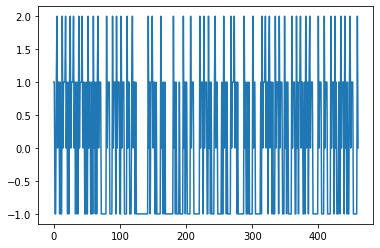

In [423]:
observers[0].plot();

In [424]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
#             print(time_step)
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [425]:
train_env.reset()
compute_avg_return(train_env,policy)

-0.4

# Entrainement
## Initialisation du premier historique

In [443]:
batch_size = 64
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

# random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
#                                                 train_env.action_spec())
# policy = random_policy
policy = agent.collect_policy

observers = [replay_buffer.add_batch,MyObserver(verbose=False)]


collect_ope_driver = dynamic_step_driver.DynamicStepDriver(
  train_env,
  policy,
  observers=observers,
  num_steps=batch_size)

initial_time_step = train_env.reset()
collect_ope_driver.run(initial_time_step,maximum_iterations=num_iterations)


dataset = replay_buffer.as_dataset(
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)


In [427]:
# next(iterator)

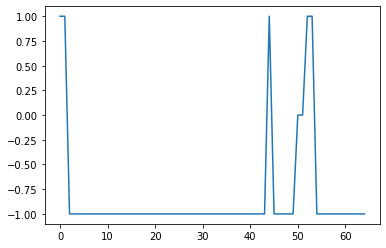

In [432]:
observers[1].plot();

## Evaluation politique de choix de agent

In [444]:
# # (Optional) Optimize by wrapping some of the code in a graph using 
# # TF function.
# agent.train = common.function(tf_agent.train)

# Reset the train step
agent.train_step_counter.assign(0)
eval_env.reset()
# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.collect_policy,10)

print(avg_return)

returns = [avg_return]

2.0


## Entrainement

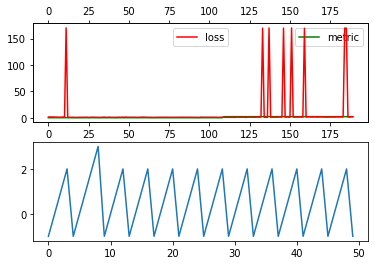

step = 190: Average Return = 2.0


KeyboardInterrupt: 

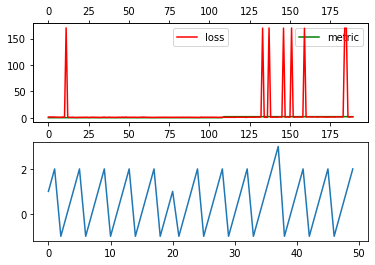

In [445]:
TOL = 1e-3
LENGTH_TOL = 100

time_step = None
losses = np.array([])
metrics = np.array([])
fig,axes = plt.subplots(2,1)
ax = axes[0]
ax2 = ax.twiny()
for _ in range(num_iterations):
    time_step, _ = collect_ope_driver.run(time_step) # FILL replay_buffer AND Observers

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    losses = np.append(losses,train_loss)

    if metrics.shape[0]:
        metrics=np.append(metrics,metrics[-1])
    else:
        metrics=np.append(metrics,0)
    

    step =agent.train_step_counter.numpy()

    if step % 10 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
   
    if step % 10 == 0:
        ax.clear()
        ax2.clear()
        ax.plot(metrics,label="metric",color="green")
        ax2.plot(losses,label="loss",color="red")
        ax.legend()
        ax2.legend()
        clear_output(wait = True)
        display(fig)
        axes[1].clear()
        observers[1].plot(ax=axes[1],sample=50)
        
    if step % 10 == 0:
        avg_return = compute_avg_return(train_env, agent.policy, \
                                        10)
        metrics[-1] = avg_return
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        
#     diff = np.abs(np.diff(metrics[-min(LENGTH_TOL,metrics.shape[0]):]))
#     if metrics.shape[0]>LENGTH_TOL+1:
#         if np.abs(np.diff(metrics[-LENGTH_TOL:])).min()<TOL:
#             break
        

In [ ]:
observers = [MyObserver()]
driver = py_driver.PyDriver(
    environment, PyTFEagerPolicy(agent.policy), observers, max_steps=10000, max_episodes=5)

In [277]:
time_spec_init = environment_eval.reset()
driver.run(time_spec_init)

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([0, 0, 0, 0], dtype=int32),
  'reward': array(0., dtype=float32),
  'step_type': array(0, dtype=int32)}),
 ())

In [278]:
[(r.get("traj").observation) for r in observers[-1].results]

[array([0, 0, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0], dtype=int32),
 array([0, 1, 0, 0],

<AxesSubplot:>

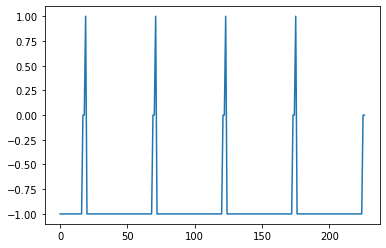

In [279]:
observers[-1].plot()